# Bioprocess GP Hybrid Model

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.integrate import odeint

from kernels import SubspaceKernel
from plots import (
	plot_predicted_profile, plot_sensitivity_results, 
	plot_optimal_conditions, plot_validation_comparison,
	create_optimization_animation
)
%config InlineBackend.figure_format = 'retina'


## Helper Functions

In [ ]:
def read_owu(file, root_path = 'dataset/interpolation/'):
    data = pd.read_csv(f'{root_path}/{file}.csv')
    owu_df = data.copy()
    num_runs = len(pd.read_csv(f'{root_path}/{file}_doe.csv'))
    if 'run' not in owu_df.columns:
        owu_df.index = pd.MultiIndex.from_product(
            [list(range(num_runs)), list(range(15))], names=["run", "time"]
        )
    else:
        owu_df.set_index(['run', 'time'], inplace=True)
    return owu_df

def read_doe(file, root_path= 'dataset/interpolation/'):
    data = pd.read_csv(f'{root_path}/{file}.csv', usecols=["feed_start", "feed_end", "Glc_feed_rate", "Glc_0", "VCD_0"])
    doe_df = data.copy()
    return doe_df

In [69]:
def owu_to_tensor(owu_raw, t_steps=15, batch_first=False):

    owu = owu_raw.copy()
    owu = owu.sort_index(level=["run", "time"])
    
    X_columns = [col for col in owu.columns if "X:" in col]
    F_columns = [col for col in owu.columns if "W:" in col]

    C_X = len(X_columns)
    C_F = len(F_columns)
    B = owu.index.get_level_values("run").nunique()
    T = t_steps

    if batch_first:
        X = np.zeros((B, T, C_X))
        F = np.zeros((B, T, C_F))

    else:
        X = np.zeros((T, C_X, B))
        F = np.zeros((T, C_F, B))

    for i, (run, group) in enumerate(owu.groupby(level="run")):
        X_group = group[X_columns].copy()
        F_group = group[F_columns].copy()

        if len(group) != T:
            raise ValueError(f"Run {run} does not have {T} time steps.")

        if batch_first:
            X[i, :, :] = X_group.values
            F[i, :, :] = F_group.values
        else:
            X[:, :, i] = X_group.values
            F[:, :, i] = F_group.values

    return X, F, X_columns, F_columns


def doe_to_tensor(doe_raw, batch_first=False):
    doe = doe_raw.copy()
    doe = doe.sort_index()
    Z_columns = [col for col in doe.columns]

    C_Z = len(Z_columns)
    T = 1
    B = doe.shape[0]

    if batch_first:
        Z = np.zeros((B, T, C_Z))
        Z[:, 0, :] = doe.values
    else:
        Z = np.zeros((T, C_Z, B))
        Z[0, :, :] = doe.values.T

    return Z, Z_columns

In [70]:
def r2(y, y_pred):
    return round(r2_score(y.flatten(), y_pred.flatten()), 3)


def absolute_rmse(y, y_pred):
    return round(root_mean_squared_error(y, y_pred), 3)


def relative_rmse(y, y_pred):
    return round(root_mean_squared_error(y, y_pred) / np.std(np.array(y)), 3)

## Prepare Dataset

In [ ]:
data_type = 'interpolation'
root_path = f'../dataset/{data_type}/'

owu = read_owu('owu', root_path=root_path)
doe = read_doe('owu_doe', root_path=root_path)

owu_test = read_owu('owu_test', root_path=root_path)
doe_test = read_doe('owu_test_doe', root_path=root_path)

In [72]:
X_train, F_train, X_columns, F_columns = owu_to_tensor(owu, t_steps=15, batch_first=True)
X_test, F_test, X_columns, F_columns = owu_to_tensor(owu_test, t_steps=15, batch_first=True)

Z_train, Z_columns = doe_to_tensor(doe, batch_first=True)
Z_test, Z_columns = doe_to_tensor(doe_test, batch_first=True)

init_volume = 1000 # mL
V_train = (init_volume + (F_train.sum(axis=-1, keepdims=True)).cumsum(axis=1)) / 1000 # L
V_test = (init_volume + (F_test.sum(axis=-1, keepdims=True)).cumsum(axis=1)) / 1000 # L

In [73]:
time_mask = np.ones(15) # T,
feed_mask = np.array([0, 1, 0, 0]) # C, 

F_train = (feed_mask[None, None, :] * F_train) / 24 # [1, 1, C] x [B, T, 1] -> [B, T, C]
F_test = (feed_mask[None, None, :] * F_test) / 24 # [1, 1, C] x [B, T, 1] -> [B, T, C]

Z_train = (time_mask[None, :, None] * Z_train) # [1, T, 1] x [B, 1, C] -> [B, T, C]
Z_test = (time_mask[None, :, None] * Z_test) # [1, T, 1] x [B, 1, C] -> [B, T, C]

In [74]:
TIME_STEP = 24
sign_mask = np.array([1, -1, 1, 1]) # C, 

In [75]:
def central_differences(X, F, V, sign_mask=None, time_step=24):
	"""
    Calculate central differences for the input data X with feed rates F and sign adjustments using sign_mask.
    
    Parameters:
    X (numpy.ndarray): Input data array of shape (batch_size, time_steps, variables)
    F (numpy.ndarray): Feed rates array of shape (batch_size, time_steps, variables)
    sign_mask (numpy.ndarray): Array to adjust signs for each variable, shape (variables,)
    time_step (int): Time step size for calculating derivatives
    
    Returns:
    numpy.ndarray: Derivatives matrix of the same shape as X
    """

	# Initial derivatives matrix
	Y = np.zeros_like(X)
	
	# Initial time step derivatives
	Y[:, 0, :] = (
		(
			(sign_mask[None, :] * (X[:, 1, :]*V[:, 1, :] - X[:, 0, :]*V[:, 0, :])) / (time_step*V[:, 0, :]) 
			+ F[:, 0, :]
		) 
	)
	
	# Central time step derivatives t=1
	Y[:, 1:-1, :] = (
		(
			(sign_mask[None, None, :] * ((X[:, 2:, :]*V[:, 2:, :] - X[:, :-2, :]*V[:, :-2, :]) / 2)) / (time_step*V[:, 1:-1, :]) 
			+ F[:, 1:-1, :]
		)
	)

	
	# Final time step derivatives
	Y[:, -1, :] = (
		(
			(sign_mask[None, :] * (X[:, -1, :]*V[:, -1, :] - X[:, -2, :]*V[:, -2, :])) / (time_step*V[:, -1, :]) 
			+ F[:, -2, :]
		)
	)

	return Y

In [76]:
Y_train = central_differences(X_train, F_train, V_train, sign_mask=sign_mask, time_step=TIME_STEP)
Y_test = central_differences(X_test, F_test, V_test, sign_mask=sign_mask, time_step=TIME_STEP)

In [77]:
def flatten_dataset(X, Z, F, Y):
	B, T, C = X.shape
	# X_flat = np.concatenate([X.reshape(B*T, C), Z[:,:,:-2].reshape(B*T, -1)], axis=1)
	X_flat = X.reshape(B*T, C)
	Y_flat = Y.reshape(B*T, C)
	F_flat = F.reshape(B*T, C)

	print(f"Flatten Shape: ")
	print(f"X + Z Columns : {X_columns}+{Z_columns}")
	print(f"X Columns: {X_columns}")
	print(f"X Shape: {X_flat.shape}")
	print(f"F Shape: {F_flat.shape}")
	print(f"X Columns: {X_columns}")
	print(f"Derivative X Shape: {Y_flat.shape}")
	return X_flat, F_flat, Y_flat

In [78]:
X_flat, F_flat, Y_flat = flatten_dataset(X_train, Z_train, F_train, Y_train)
X_test_flat, F_test_flat, Y_test_flat = flatten_dataset(X_test, Z_test, F_test, Y_test)

Flatten Shape: 
X + Z Columns : ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']+['feed_start', 'feed_end', 'Glc_feed_rate', 'Glc_0', 'VCD_0']
X Columns: ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']
X Shape: (750, 4)
F Shape: (750, 4)
X Columns: ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']
Derivative X Shape: (750, 4)
Flatten Shape: 
X + Z Columns : ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']+['feed_start', 'feed_end', 'Glc_feed_rate', 'Glc_0', 'VCD_0']
X Columns: ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']
X Shape: (750, 4)
F Shape: (750, 4)
X Columns: ['X:VCD', 'X:Glc', 'X:Lac', 'X:Titer']
Derivative X Shape: (750, 4)


## Model Training

In [79]:
def fit_gp_model(X, y):
    n_features = X.shape[-1]

    # Apply RBF kernel to the normal features
    raw_feature_kernel = RBF(length_scale=[1e-1] * n_features, length_scale_bounds=(1e-2, 1e2))

    # The SubspaceKernel ensures that the RBF kernel is only applied to the first 10 features
    feature_kernel = SubspaceKernel(
        raw_feature_kernel, ids_to_apply=np.arange(0, n_features)
    )

    # Noise kernal
    noise_kernel = WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))

    # Combine the kernel and allow for Noise
    full_kernel = 1**2 * feature_kernel + noise_kernel
    gp_model = GaussianProcessRegressor(kernel=full_kernel, n_restarts_optimizer=3)

    # Fit GP model
    gp_model.fit(X, y)
    return gp_model

In [80]:
models = {}
for i, var_name in tqdm(enumerate(X_columns),
                        desc="Training: ",
                        total=len(X_columns),
                        leave=True,
                        ncols=80):

    model = fit_gp_model(X_flat, Y_flat[:, i])
    models[i] = model

Training:   0%|                                           | 0/4 [00:00<?, ?it/s]/Users/tim/miniforge3/envs/DRL/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.

Training:  25%|████████▊                          | 1/4 [00:04<00:12,  4.30s/it]/Users/tim/miniforge3/envs/DRL/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.

/Users/tim/miniforge3/envs/DRL/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specifie

In [81]:
def ode_fcn(t, y, models, feeds=None, volumes=None, sign_mask=None):
    """
    --- Inputs ---
    t: Current timestep of the process
    y: Current states of VCD and Glucose
    feed: Feed rate for the experimentf
    g_mdl, k_mdl: Models for derivatives of growth and consumption rate
                  (sklearn expects 2D array, even when predicting on a single observation, use .reshape(1, -1))
    --- Outputs ---
    dVCD_dt, dGlc_df : Derivatives of VCD and Glucose for the next state from current one
    """
    # Current time index
    time_idx = int(t // 24)
    
    # Ensure time index does not exceed feed array bounds
    time_idx = min(time_idx, feeds.shape[0] - 1)

    # Get current feed rate
    current_feeds = feeds[time_idx]

    curr_volume = volumes[time_idx-1][0]
    after_feed_volume = volumes[time_idx][0]

    # mass balances
    dX_dt = np.zeros(len(models))
    for i, model in models.items():
        dX_dt[i] = (
            sign_mask[i] * model.predict(y.reshape(1, -1))[0] * curr_volume  
            + current_feeds[i] * after_feed_volume 
            - (y[i] * (after_feed_volume - curr_volume) / 24)
            ) / after_feed_volume

    return dX_dt


In [82]:
def run_hybrid(X, Z, F, V, models, t_end=14, time_step=24, sign_mask=None):
    """
    --- Inputs ---
    VCD_0, Glc_0: Initial conditions
    feed: Feed rate for the experiment
    t_end: End time of feed/experiment
    g_mdl, k_mdl: Models for derivatives of growth and consumption rate
    --- Outputs ---
    t: array of timesteps
    VCD, Glc: array of VCD/Glc values as evolution over the experiment run
    """
    X_pred = np.zeros_like(X)

    for i in tqdm(range(len(X)), desc="Simulating: ", total=len(X), leave=False, ncols=80):
        # Initial Values
        init_values = np.array([Z[i, 0, -1], Z[i, 0, -2], 0, 0])

        # Get all the time-steps on which we want to predict
        t_eval = np.arange(0, t_end * time_step + time_step, time_step)  # T,

        # Get feed rate data
        feeds = F[i, :, :]

        volumes = V[i, :, :]

        X_pred[i, :, :] = odeint(
            func=ode_fcn,
            y0=init_values,
            t=t_eval,
            args=(models, feeds, volumes, sign_mask),
            tfirst=True,
        )  # T, C

    return X_pred

## Simulation

In [83]:
X_train_pred = run_hybrid(X=X_train, Z=Z_train, F=F_train, V=V_train, models=models, t_end=14, time_step=24, sign_mask=sign_mask)
X_test_pred = run_hybrid(X=X_test, Z=Z_test, F=F_test, V=V_test, models=models, t_end=14, time_step=24, sign_mask=sign_mask)

In [84]:
print("Train Set")
for i, var in enumerate(X_columns):
    # Calculate error metrics
    rmse = relative_rmse(X_train[:, :, i], X_train_pred[:, :, i])
    score = r2(X_train[:, :, i], X_train_pred[:, :, i])
    print(f'{var} Train RMSE: {rmse}, R2: {score}')

print("\nTest Set")    
for i, var in enumerate(X_columns):
    # Calculate error metrics
    rmse = relative_rmse(X_test[:, :, i], X_test_pred[:, :, i])
    score = r2(X_test[:, :, i], X_test_pred[:, :, i])
    print(f'{var} Test RMSE: {rmse}, R2: {score}')

Train Set
X:VCD Train RMSE: 0.351, R2: 0.843
X:Glc Train RMSE: 0.324, R2: 0.87
X:Lac Train RMSE: 0.187, R2: 0.948
X:Titer Train RMSE: 0.402, R2: 0.718

Test Set
X:VCD Test RMSE: 0.302, R2: 0.886
X:Glc Test RMSE: 0.425, R2: 0.761
X:Lac Test RMSE: 0.154, R2: 0.967
X:Titer Test RMSE: 0.337, R2: 0.8


In [85]:
plot_predicted_profile(
    X_test.transpose(1, 2, 0), 
	X_test_pred.transpose(1, 2, 0), 
	X_columns, select_runs=[20, 21, 22, 23, 24], height=500
)

## Sensitivity Analysis

In [86]:
def sensitivity_analysis(models, init_conditions, process_params, param_name, param_range, time_points, sign_mask):
    """
    Perform sensitivity analysis for a specific parameter.
    """
    results = []
    
    for param_value in param_range:
        # Create copies of parameters
        params = process_params.copy()
        init_conds = init_conditions.copy()
        
        # Update parameter value
        if param_name in params:
            params[param_name] = param_value
        elif param_name in init_conds:
            init_conds[param_name] = param_value
        else:
            print(f"Parameter {param_name} not found")
            continue
            
        try:
            # Create input arrays for simulation
            B = 1  # Single run
            T = len(time_points)
            C = 4  # Number of state variables
            
            # Initialize arrays
            X = np.zeros((B, T, C))
            Z = np.zeros((B, T, 5))  # Match the structure from doe_to_tensor
            F = np.zeros((B, T, C))
            
            # Set initial conditions for all time steps
            for t in range(T):
                Z[0, t] = [params['feed_start'], params['feed_end'], 
                          params['Glc_feed_rate'], init_conds['Glc_0'], 
                          init_conds['VCD_0']]
            
            # Set feed rates based on process parameters
            feed_idx = np.where((time_points >= params['feed_start']) & 
                              (time_points <= params['feed_end']))[0]
            if len(feed_idx) > 0:
                F[0, feed_idx, 1] = params['Glc_feed_rate'] / 24  # Convert to hourly rate
            
            # Calculate volumes - reshape to match expected dimensions
            init_volume = 1000  # mL
            V = np.zeros((B, T, 1))
            cumsum_feeds = (F[0].sum(axis=1)).cumsum()
            V[0, :, 0] = (init_volume + cumsum_feeds) / 1000  # L
            
            # Run simulation
            X_pred = run_hybrid(X=X, Z=Z, F=F, V=V, models=models, 
                              t_end=len(time_points)-1, time_step=24, 
                              sign_mask=sign_mask)
            
            # Store results
            results.append({
                'param_value': param_value,
                'predictions': X_pred[0]  # Take first batch
            })
            
        except Exception as e:
            print(f"Error in simulation for {param_name}={param_value}: {str(e)}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            continue
            
    return results

def run_sensitivity_analysis(models, params_to_analyze, time_points, sign_mask):
    """Run sensitivity analysis for key process parameters"""
    
    # Define base conditions with default values from your training data
    init_conditions = {
        'VCD_0': 0.8,  # Initial VCD
        'Glc_0': 50,   # Initial glucose
    }
    
    process_params = {
        'feed_start': 2,
        'feed_end': 10,
        'Glc_feed_rate': 10
    }
    
    sensitivity_results = {}
    for param_name, param_range in params_to_analyze.items():
        print(f"Analyzing sensitivity for {param_name}...")
        results = sensitivity_analysis(
            models, init_conditions.copy(), process_params.copy(),
            param_name, param_range, time_points, sign_mask
        )
        
        if results:  # Only store and plot if we have results
            sensitivity_results[param_name] = results
        
    return sensitivity_results



# Time points
time_points = np.arange(15)

# Parameters to analyze with smaller ranges
params_to_analyze = {
    'feed_start': np.array([1, 2, 3, 4]),
    'feed_end': np.array([8, 9, 10, 11]),
    'Glc_feed_rate': np.array([5, 10, 15, 20]),
    'VCD_0': np.array([0.5, 0.7, 0.9, 1.1]),
    'Glc_0': np.array([30, 45, 60, 75])
}

# Run sensitivity analysis
sensitivity_results = run_sensitivity_analysis(models, params_to_analyze, time_points, sign_mask)

Analyzing sensitivity for feed_start...


Analyzing sensitivity for feed_end...


Analyzing sensitivity for Glc_feed_rate...


Analyzing sensitivity for VCD_0...


Analyzing sensitivity for Glc_0...


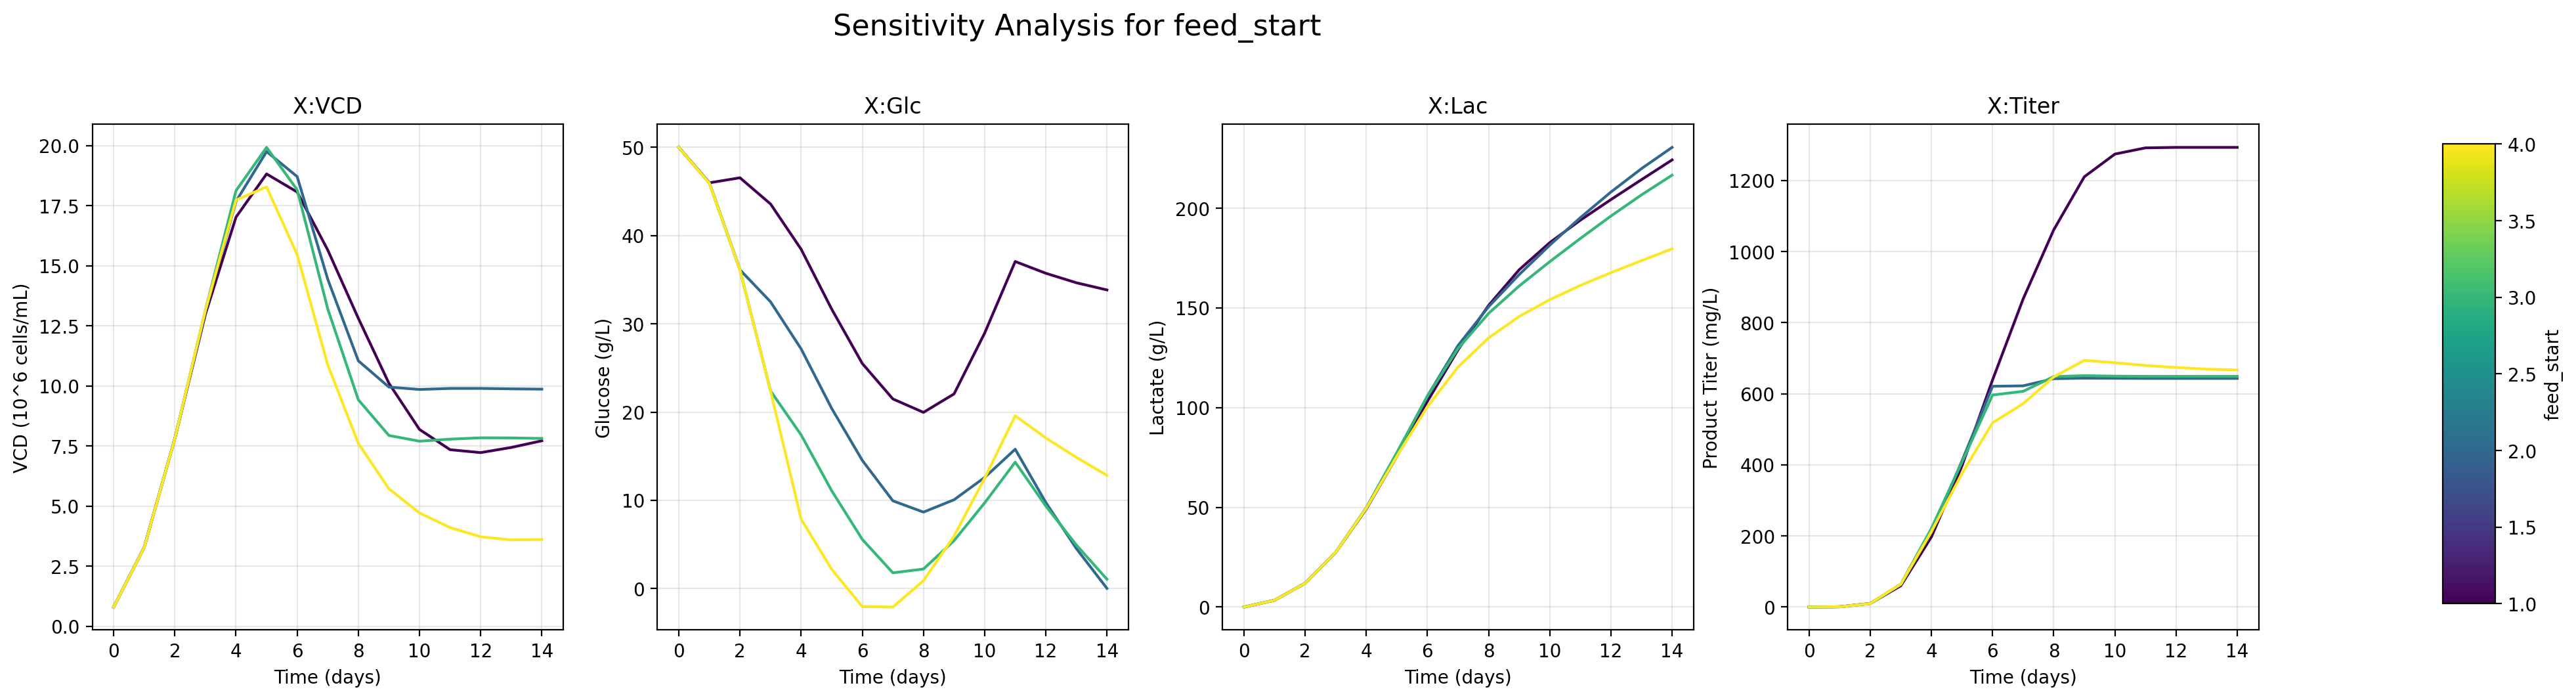

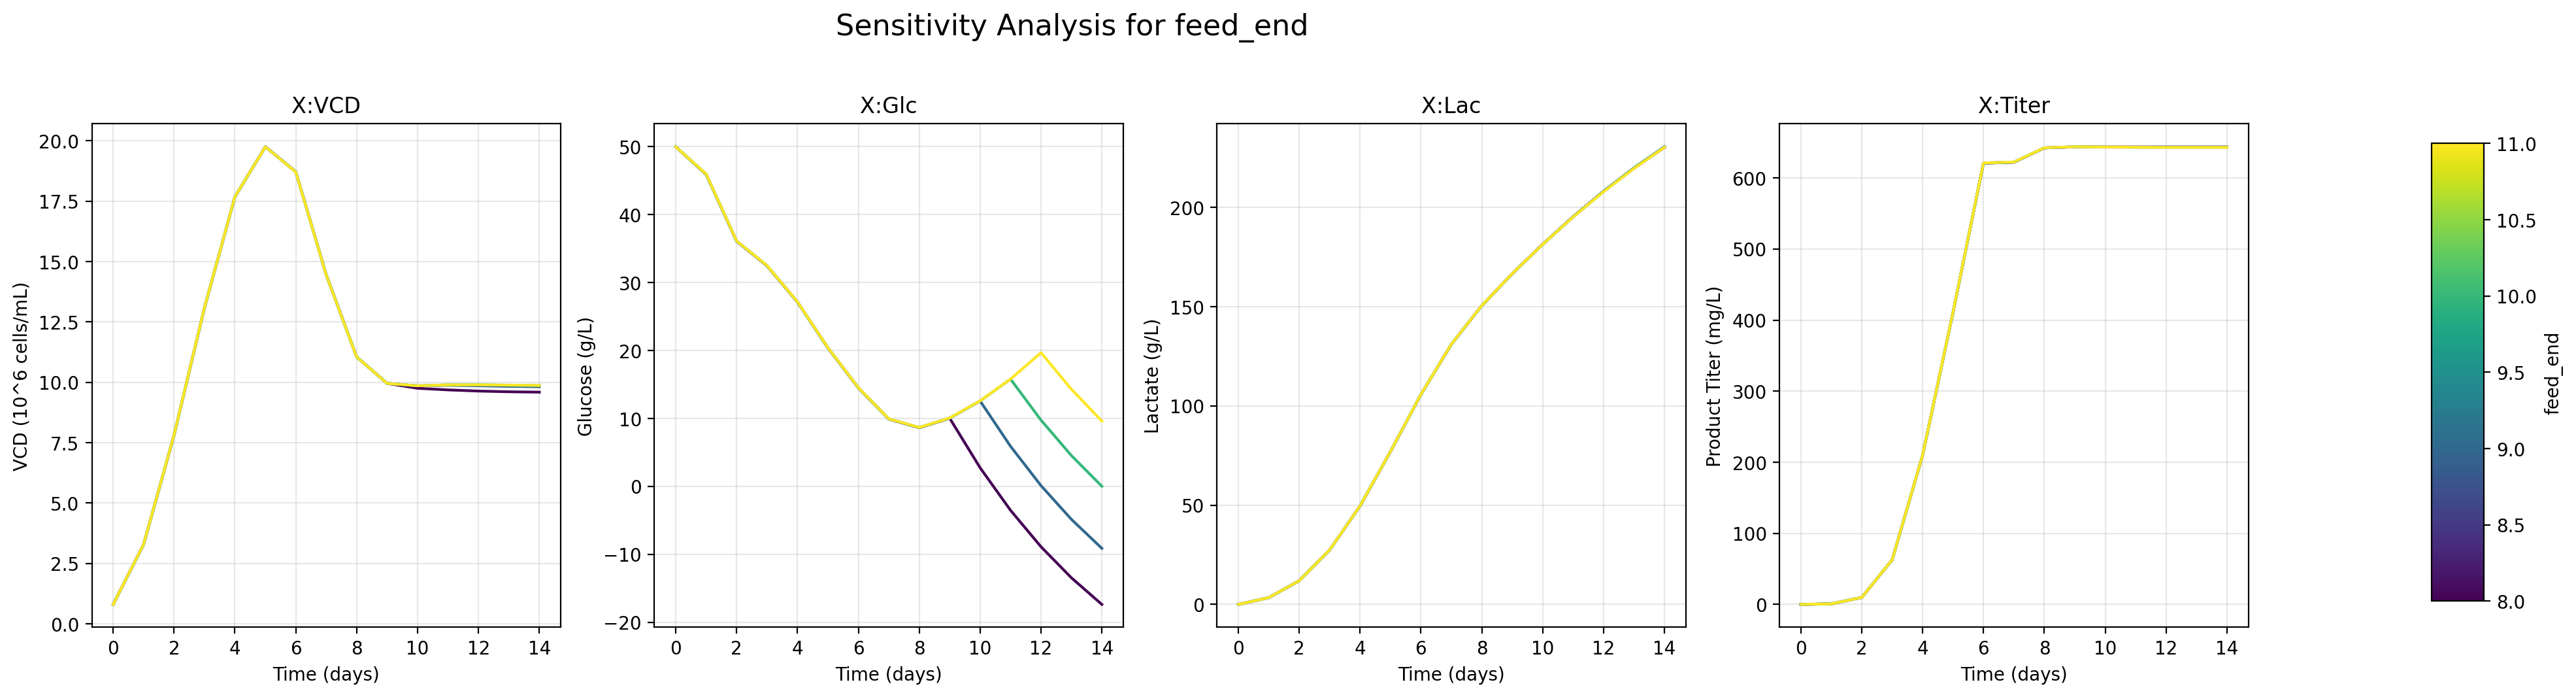

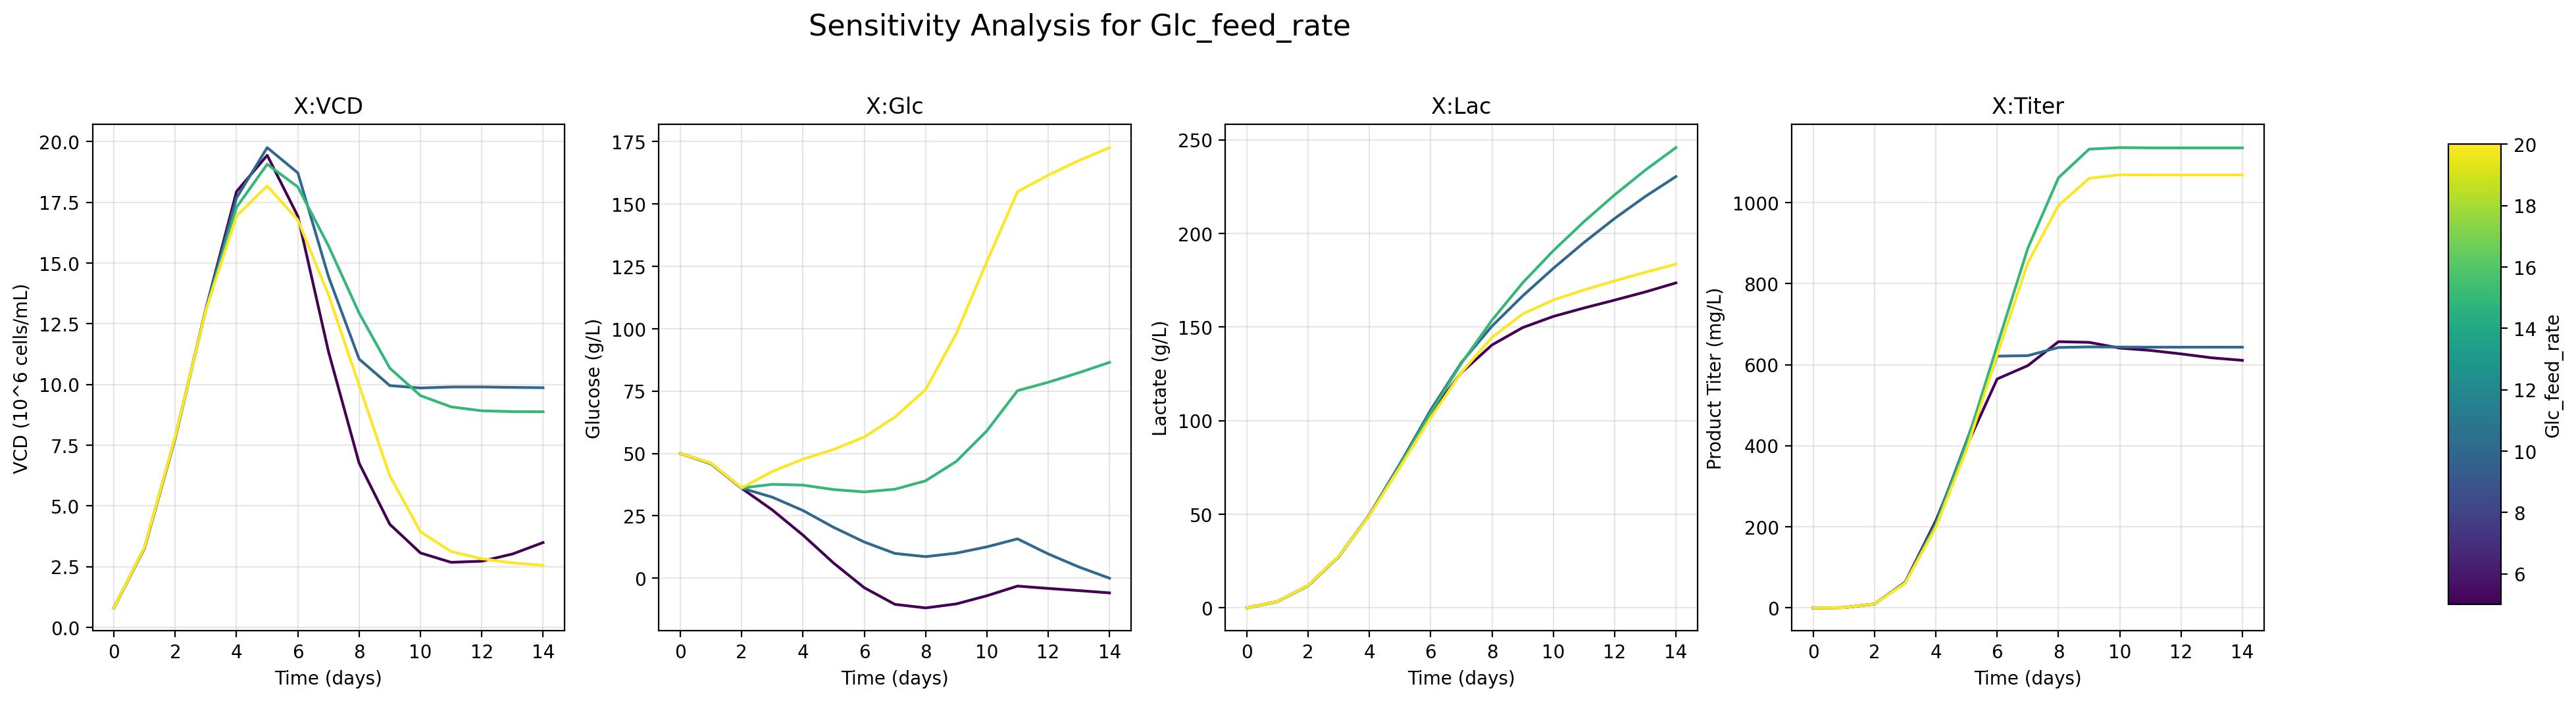

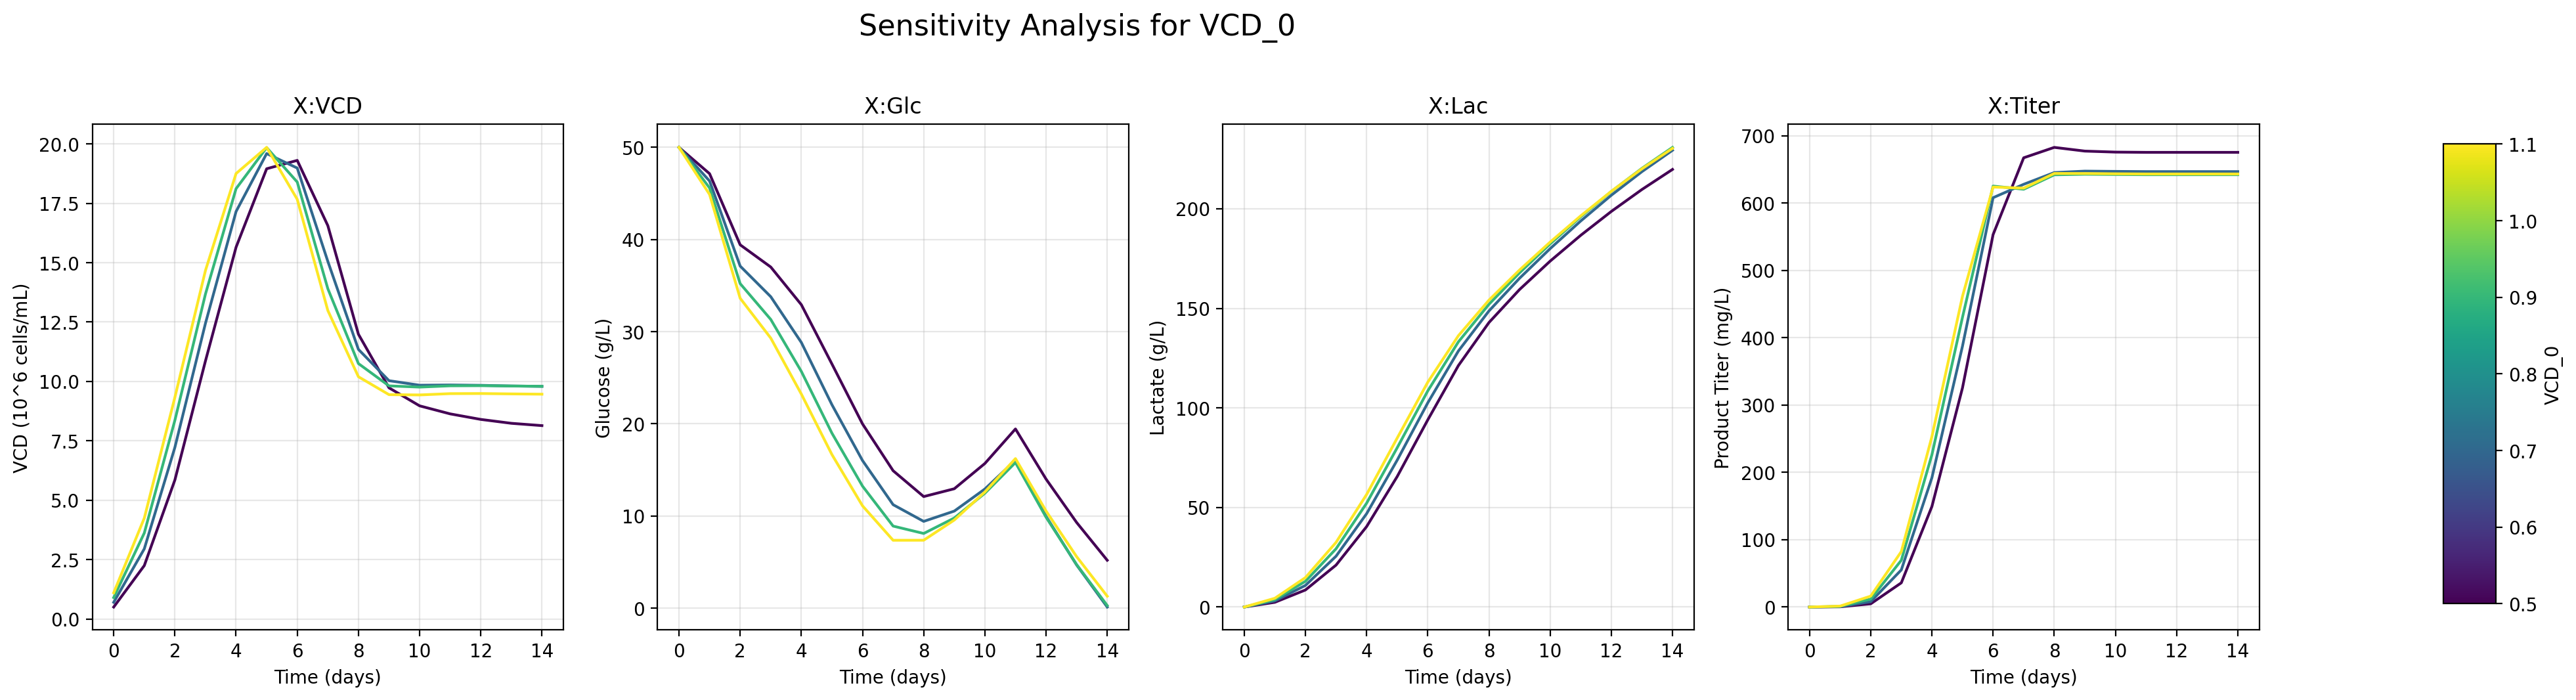

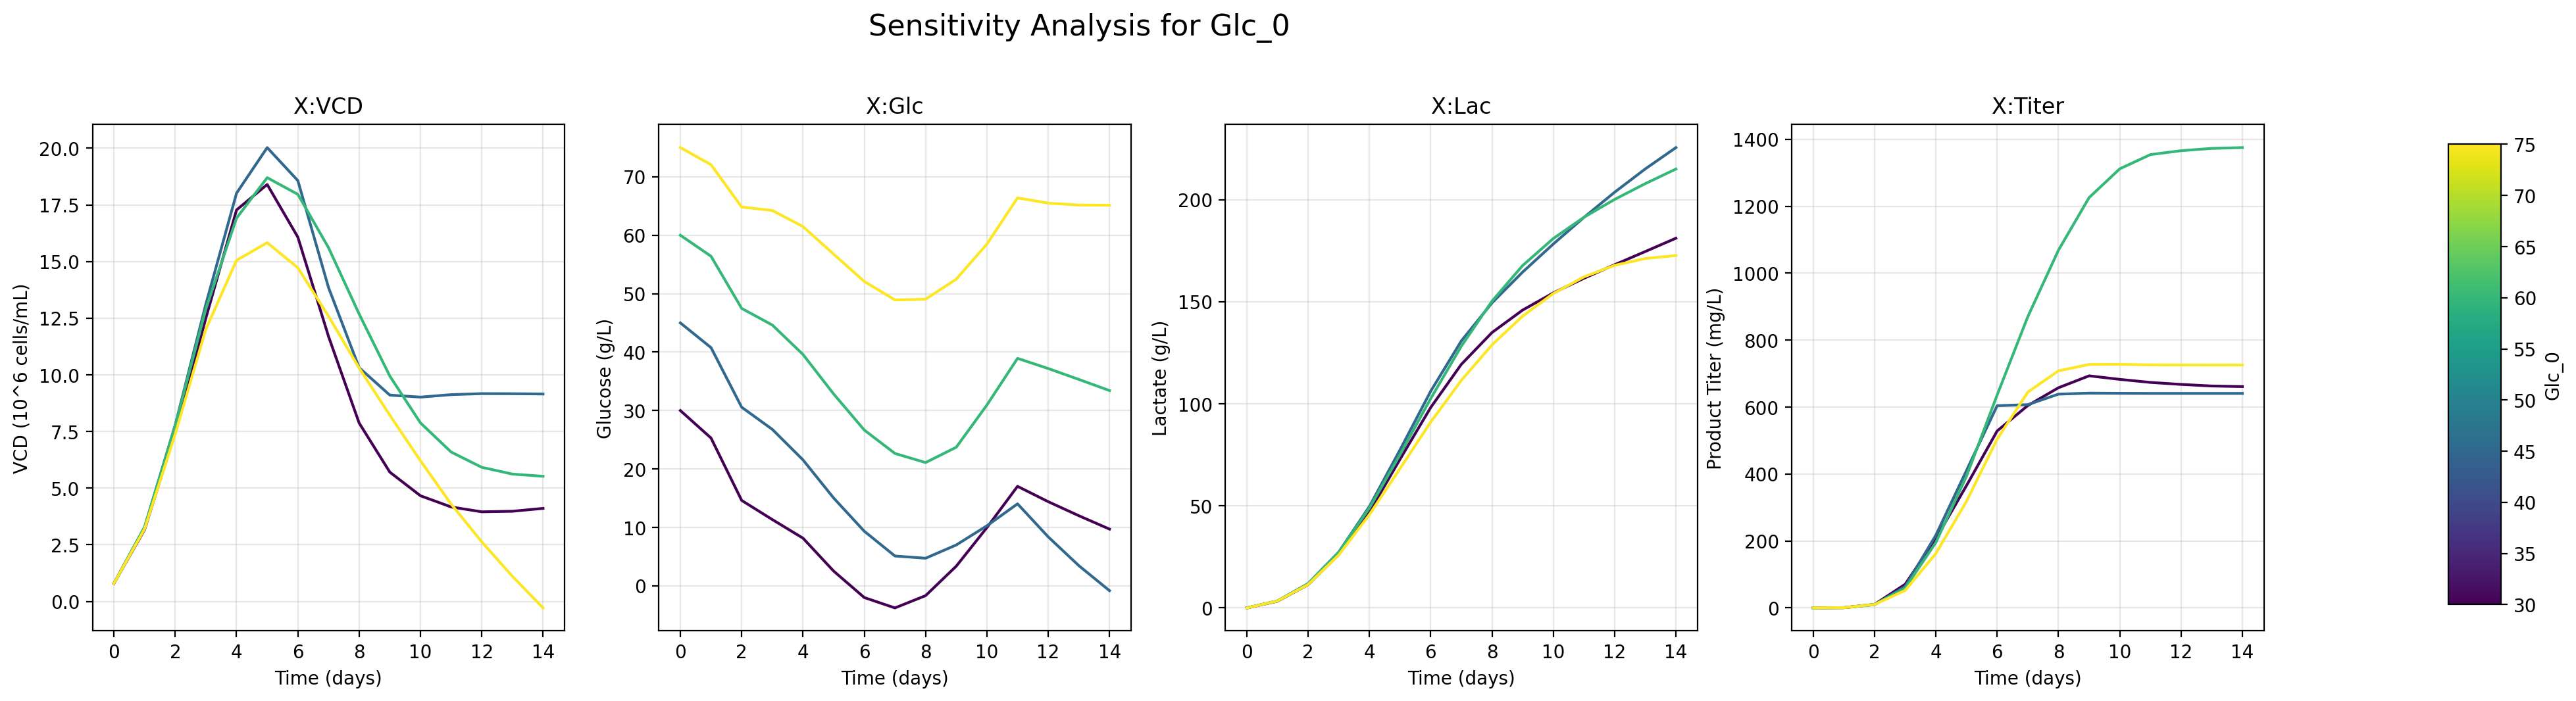

In [87]:
# Plot and save results
plot_sensitivity_results(sensitivity_results, time_points, X_columns)

## Random Optimization

In [117]:
def optimize_process_conditions(models, init_conditions, param_ranges, time_points, sign_mask, 
                                num_samples=100, seed=42, verbose=True):
    """
    Use the hybrid model to find optimal process conditions through random sampling.
    
    Args:
        models: Dictionary of trained GP models
        init_conditions: Dictionary of initial conditions
        param_ranges: Dictionary of parameter ranges to explore
        time_points: Array of time points for simulation
        sign_mask: Array of signs for each state variable
        num_samples: Number of parameter combinations to try
        
    Returns:
        Dictionary with optimal parameters and predicted profiles
    """
    # Set random seed for reproducibility 
    np.random.seed(seed)

    # Generate random parameter combinations
    param_samples = {}
    for param, (min_val, max_val) in param_ranges.items():
        param_samples[param] = np.random.uniform(min_val, max_val, num_samples)
    
    # Create parameter combinations
    param_combinations = []
    for i in range(num_samples):
        params = {}
        for param, values in param_samples.items():
            params[param] = values[i]
        param_combinations.append(params)
    
    # Simulate each parameter combination
    results = []
    for i, params in enumerate(param_combinations):
        # Set process parameters
        process_params = {
            'feed_start': params.get('feed_start', init_conditions['feed_start']),
            'feed_end': params.get('feed_end', init_conditions['feed_end']),
            'Glc_feed_rate': params.get('Glc_feed_rate', init_conditions['Glc_feed_rate'])
        }
        
        # Set initial conditions
        init_conds = {
            'VCD_0': params.get('VCD_0', init_conditions['VCD_0']),
            'Glc_0': params.get('Glc_0', init_conditions['Glc_0'])
        }
        
        try:
            # Create input arrays for simulation
            B = 1  # Single run
            T = len(time_points)
            C = 4  # Number of state variables
            
            # Initialize arrays
            X = np.zeros((B, T, C))
            Z = np.zeros((B, T, 5))
            F = np.zeros((B, T, C))
            
            # Set initial conditions for all time steps
            for t in range(T):
                Z[0, t] = [process_params['feed_start'], process_params['feed_end'],
                          process_params['Glc_feed_rate'], init_conds['Glc_0'],
                          init_conds['VCD_0']]
            
            # Set feed rates
            feed_idx = np.where((time_points >= process_params['feed_start']) &
                              (time_points <= process_params['feed_end']))[0]
            if len(feed_idx) > 0:
                F[0, feed_idx, 1] = process_params['Glc_feed_rate'] / 24
            
            # Calculate volumes
            init_volume = 1000  # mL
            V = np.zeros((B, T, 1))
            cumsum_feeds = (F[0].sum(axis=1)).cumsum()
            V[0, :, 0] = (init_volume + cumsum_feeds) / 1000  # L
            
            # Run simulation
            X_pred = run_hybrid(X=X, Z=Z, F=F, V=V, models=models,
                              t_end=len(time_points)-1, time_step=24,
                              sign_mask=sign_mask)
            
            # Get final titer
            final_titer = X_pred[0, -1, 3]  # Last timepoint, titer variable
            
            results.append({
                'params': params,
                'final_titer': final_titer,
                'predictions': X_pred[0],
                'time_points': time_points
            })
            
        except Exception as e:
            print(f"Error in simulation {i}: {str(e)}")
            continue
            
        if (i + 1) % 10 == 0:
            print(f"Simulated {i + 1}/{num_samples} parameter combinations")
    
    if not results:
        print("No valid results obtained from simulations")
        return None
    
    # Sort by final titer and get the best
    results.sort(key=lambda x: x['final_titer'], reverse=True)
    best_result = results[0]
    
    if verbose:
        print("\nOptimal process conditions:")
        for param, value in best_result['params'].items():
            print(f"{param}: {value:.4f}")
        print(f"Predicted final titer: {best_result['final_titer']:.2f} mg/L")
    
    return best_result

In [113]:
# Define initial conditions and parameter ranges
init_conditions = {
    'VCD_0': 0.8,
    'Glc_0': 50,
    'feed_start': 2,
    'feed_end': 10,
    'Glc_feed_rate': 10
}

param_ranges = {
    'feed_start': (1.0, 5.0),
    'feed_end': (8.0, 12.0),
    'Glc_feed_rate': (5.0, 20.0),
    'VCD_0': (0.5, 1.1),
    'Glc_0': (30.0, 75.0)
}

# Run optimization
time_points = np.arange(15)

seed = 42

optimal_result = optimize_process_conditions(
    models=models,
    init_conditions=init_conditions,
    param_ranges=param_ranges,
    time_points=time_points,
    sign_mask=sign_mask,
    num_samples=100,
	seed=seed,
)

Simulated 10/100 parameter combinations


Simulated 20/100 parameter combinations


Simulated 30/100 parameter combinations


Simulated 40/100 parameter combinations


Simulated 50/100 parameter combinations


Simulated 60/100 parameter combinations


Simulated 70/100 parameter combinations


Simulated 80/100 parameter combinations


Simulated 90/100 parameter combinations


Simulated 100/100 parameter combinations

Optimal process conditions:
feed_start: 3.9160
feed_end: 8.6975
Glc_feed_rate: 12.5227
VCD_0: 0.6914
Glc_0: 74.6834
Predicted final titer: 1604.01 mg/L


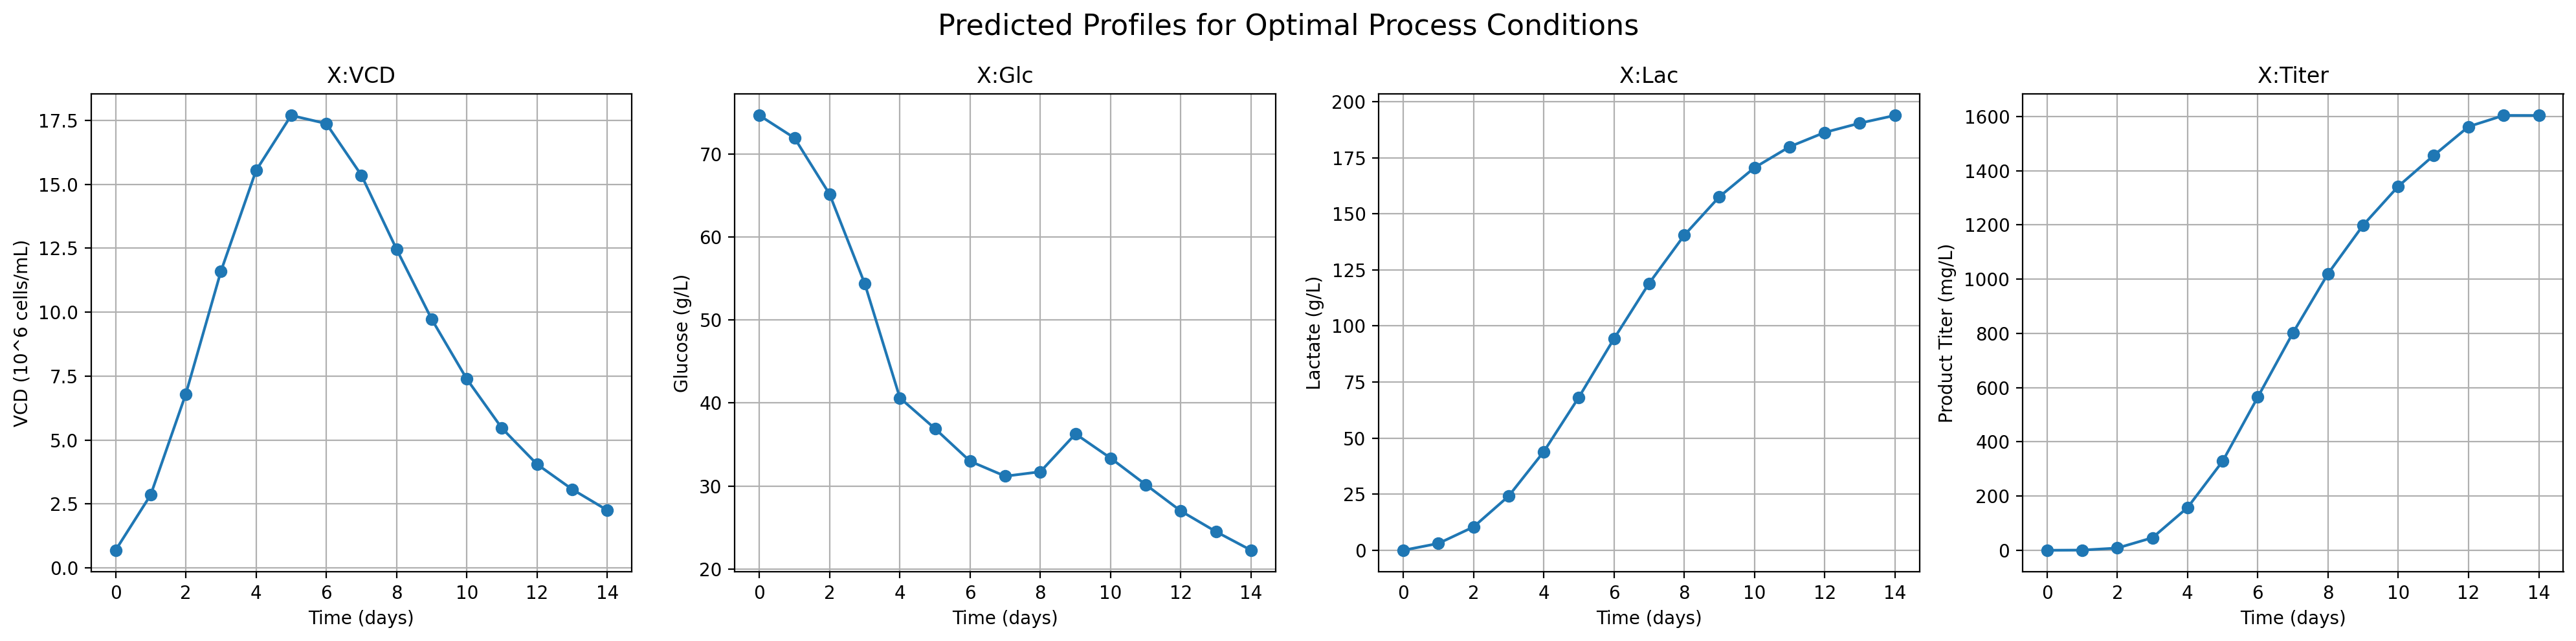

In [121]:
# Plot the predicted profiles for the optimal conditions
plot_optimal_conditions(optimal_result, X_columns)

In [97]:
def print_statistical_comparison(optimal_result, X_train, X_test):
    """
    Print statistical comparison between optimal result and historical data.
    
    Args:
        optimal_result: Dictionary containing optimization results
        X_train: Training data array
        X_test: Test data array
    """
    print("\n=== Statistical Validation ===")
    
    # Calculate statistics from training and test data
    train_max_titer = np.max(X_train[:, -1, 3])
    test_max_titer = np.max(X_test[:, -1, 3])
    train_mean_titer = np.mean(X_train[:, -1, 3])
    test_mean_titer = np.mean(X_test[:, -1, 3])
    
    print(f"Optimal titer: {optimal_result['final_titer']:.2f} mg/L")
    print(f"Training data - Max titer: {train_max_titer:.2f} mg/L, Mean titer: {train_mean_titer:.2f} mg/L")
    print(f"Test data - Max titer: {test_max_titer:.2f} mg/L, Mean titer: {test_mean_titer:.2f} mg/L")
    
    # Calculate improvement percentage
    improvement_over_train = ((optimal_result['final_titer'] - train_max_titer) / train_max_titer) * 100
    improvement_over_test = ((optimal_result['final_titer'] - test_max_titer) / test_max_titer) * 100
    
    print(f"\nImprovement over training max: {improvement_over_train:.1f}%")
    print(f"Improvement over test max: {improvement_over_test:.1f}%")
    
    if improvement_over_train > 50 or improvement_over_test > 50:
        print("\nWarning: Unusually large improvement - verify model predictions")

def check_biological_constraints(optimal_result):
    """
    Check if optimal results satisfy biological constraints.
    
    Args:
        optimal_result: Dictionary containing optimization results
    """
    print("\n=== Biological Constraints Check ===")
    
    params = optimal_result['params']
    predictions = optimal_result['predictions']
    
    constraints = {
        'VCD peak should be realistic': {
            'check': np.max(predictions[:, 0]) < 25,
            'value': f"Max VCD: {np.max(predictions[:, 0]):.2f}"
        },
        'Glucose should not accumulate excessively': {
            'check': np.max(predictions[:, 1]) < 100,
            'value': f"Max Glucose: {np.max(predictions[:, 1]):.2f}"
        },
        'Lactate should not be too high': {
            'check': np.max(predictions[:, 2]) < 300,
            'value': f"Max Lactate: {np.max(predictions[:, 2]):.2f}"
        },
        'Feed timing is logical': {
            'check': params['feed_end'] > params['feed_start'],
            'value': f"Feed window: {params['feed_start']:.1f} to {params['feed_end']:.1f}"
        }
    }
    
    for constraint, details in constraints.items():
        status = '✓' if details['check'] else '✗'
        print(f"{status} {constraint}: {details['value']}")

def run_sensitivity_simulation(test_params, models, time_points, sign_mask):
    """
    Run a single sensitivity simulation with given parameters.
    
    Args:
        test_params: Dictionary of test parameters
        models: Trained models
        time_points: Array of time points
        sign_mask: Array of signs for each state variable
    
    Returns:
        Final titer value from simulation
    """
    B, T, C = 1, len(time_points), 4
    X = np.zeros((B, T, C))
    Z = np.zeros((B, T, 5))
    F = np.zeros((B, T, C))
    
    # Set conditions
    for t in range(T):
        Z[0, t] = [test_params['feed_start'], test_params['feed_end'],
                   test_params['Glc_feed_rate'], test_params['Glc_0'],
                   test_params['VCD_0']]
    
    # Set feed rates
    feed_idx = np.where((time_points >= test_params['feed_start']) &
                       (time_points <= test_params['feed_end']))[0]
    if len(feed_idx) > 0:
        F[0, feed_idx, 1] = test_params['Glc_feed_rate'] / 24
    
    # Calculate volumes
    init_volume = 1000
    V = np.zeros((B, T, 1))
    cumsum_feeds = (F[0].sum(axis=1)).cumsum()
    V[0, :, 0] = (init_volume + cumsum_feeds) / 1000
    
    # Run simulation
    X_pred = run_hybrid(X=X, Z=Z, F=F, V=V, models=models,
                       t_end=len(time_points)-1, time_step=24,
                       sign_mask=sign_mask)
    
    return X_pred[0, -1, 3]

def validate_optimal_results(optimal_result, models, X_train, X_test, time_points, sign_mask):
    """
    Validate the optimal results through multiple perspectives
    by perform sensitivity analysis around optimal point.
    
    Args:
        optimal_result: Dictionary containing optimization results
        X_train: Training data array
        X_test: Test data array
        models: Trained models
        time_points: Array of time points
        sign_mask: Array of signs for each state variable
    """
    # Run all validations
    print_statistical_comparison(optimal_result, X_train, X_test)
    check_biological_constraints(optimal_result)

    print("\n=== Sensitivity Analysis Validation ===")
    
    params = optimal_result['params']
    variations = 0.1  # 10% variation
    
    sensitivity_checks = {}
    for param_name, value in params.items():
        lower_value = value * (1 - variations)
        higher_value = value * (1 + variations)
        
        # Create parameter sets for sensitivity check
        param_sets = []
        for test_value in [lower_value, value, higher_value]:
            test_params = params.copy()
            test_params[param_name] = test_value
            param_sets.append(test_params)
        
        # Simulate each parameter set
        titers = []
        for test_params in param_sets:
            try:
                titer = run_sensitivity_simulation(test_params, models, time_points, sign_mask)
                titers.append(titer)
            except Exception as e:
                print(f"Error in sensitivity check for {param_name}: {str(e)}")
                titers.append(None)
        
        if all(titer is not None for titer in titers):
            sensitivity_checks[param_name] = {
                'values': [lower_value, value, higher_value],
                'titers': titers
            }
    
    # Print sensitivity results
    for param_name, results in sensitivity_checks.items():
        print(f"\nParameter: {param_name}")
        for val, titer in zip(results['values'], results['titers']):
            print(f"  Value: {val:.3f} -> Titer: {titer:.2f}")
        
        # Check if optimal is actually optimal locally
        if results['titers'][1] < max(results['titers']):
            print(f"Warning: {param_name} might not be at local optimum!")

In [98]:
validate_optimal_results(
    optimal_result,
	models,
    X_train,
    X_test,
    time_points,
    sign_mask
)


=== Statistical Validation ===
Optimal titer: 1604.01 mg/L
Training data - Max titer: 1582.55 mg/L, Mean titer: 1150.42 mg/L
Test data - Max titer: 1593.97 mg/L, Mean titer: 1301.24 mg/L

Improvement over training max: 1.4%
Improvement over test max: 0.6%

=== Biological Constraints Check ===
✓ VCD peak should be realistic: Max VCD: 17.69
✓ Glucose should not accumulate excessively: Max Glucose: 74.68
✓ Lactate should not be too high: Max Lactate: 193.88
✓ Feed timing is logical: Feed window: 3.9 to 8.7

=== Sensitivity Analysis Validation ===



Parameter: feed_start
  Value: 3.524 -> Titer: 1604.01
  Value: 3.916 -> Titer: 1604.01
  Value: 4.308 -> Titer: 1465.11

Parameter: feed_end
  Value: 7.828 -> Titer: 1468.50
  Value: 8.697 -> Titer: 1604.01
  Value: 9.567 -> Titer: 1475.18

Parameter: Glc_feed_rate
  Value: 11.270 -> Titer: 1616.42
  Value: 12.523 -> Titer: 1604.01
  Value: 13.775 -> Titer: 1584.69

Parameter: VCD_0
  Value: 0.622 -> Titer: 1603.83
  Value: 0.691 -> Titer: 1604.01
  Value: 0.761 -> Titer: 1602.53

Parameter: Glc_0
  Value: 67.215 -> Titer: 989.17
  Value: 74.683 -> Titer: 1604.01
  Value: 82.152 -> Titer: 584.95


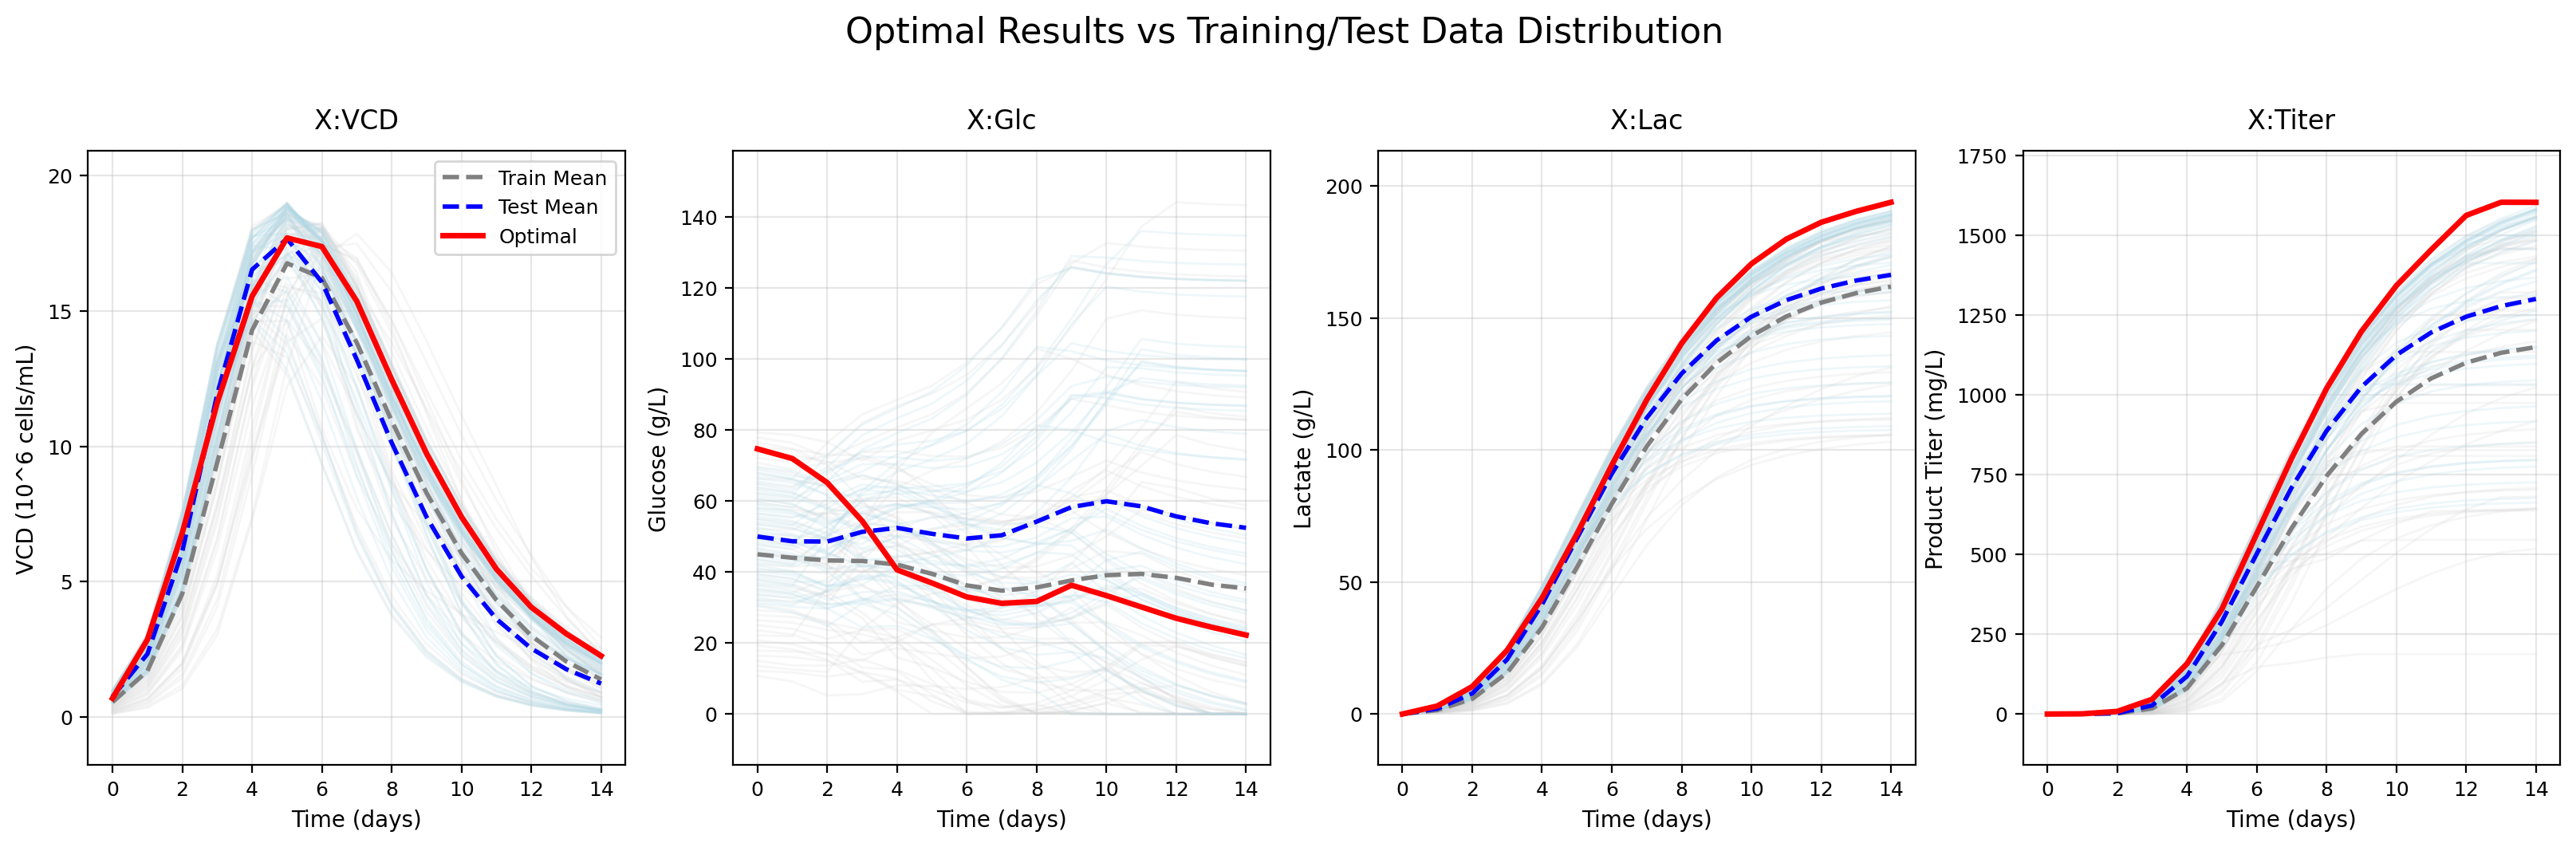

In [100]:
plot_validation_comparison(
    optimal_result,
    X_train,
    X_test,
    X_columns,
    time_points
)

## Save and Load

In [122]:
def save_hybrid_model(models, sign_mask, save_path='hybrid_model.pkl'):
    """
    Save hybrid model and its components.
    
    Args:
        models: Dictionary of trained GP models
        sign_mask: Array of signs for each state variable
        save_path: Path to save the model file
    """
    import pickle
    
    model_data = {
        'models': models,
        'sign_mask': sign_mask
    }
    
    with open(save_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved to {save_path}")

def load_hybrid_model(load_path='hybrid_model.pkl'):
    """
    Load hybrid model and its components.
    
    Args:
        load_path: Path to the saved model file
    
    Returns:
        models: Dictionary of trained GP models
        sign_mask: Array of signs for each state variable
    """
    import pickle
    
    with open(load_path, 'rb') as f:
        model_data = pickle.load(f)
    
    models = model_data['models']
    sign_mask = model_data['sign_mask']
    
    print(f"Model loaded from {load_path}")
    return models, sign_mask


In [123]:
save_hybrid_model(models, sign_mask, 'hybrid_model.pkl')

Model saved to hybrid_model.pkl


In [124]:
loaded_models, loaded_sign_mask = load_hybrid_model('hybrid_model.pkl')

Model loaded from hybrid_model.pkl


In [125]:
X_test_pred = run_hybrid(X=X_test, Z=Z_test, F=F_test, V=V_test, 
						 models=loaded_models, t_end=14, time_step=24, sign_mask=loaded_sign_mask)

In [126]:
plot_predicted_profile(
    X_test.transpose(1, 2, 0), 
	X_test_pred.transpose(1, 2, 0),
	X_columns, select_runs=[20, 21, 22, 23, 24], height=500
)

## Watch A Optimized Progress 

In [128]:
# Define initial conditions and parameter ranges
init_conditions = {
    'VCD_0': 0.8,
    'Glc_0': 50,
    'feed_start': 2,
    'feed_end': 10,
    'Glc_feed_rate': 10
}

param_ranges = {
    'feed_start': (1.0, 5.0),
    'feed_end': (8.0, 12.0),
    'Glc_feed_rate': (5.0, 20.0),
    'VCD_0': (0.5, 1.1),
    'Glc_0': (30.0, 75.0)
}

# Run optimization
time_points = np.arange(15)

seed = 42

results = []
for i in range(100):
    result = optimize_process_conditions(
        models=models,
        init_conditions=init_conditions,
        param_ranges=param_ranges,
        time_points=time_points,
        sign_mask=sign_mask,
        num_samples=1,
        seed=i,
        verbose=False
    )
    if result:
        results.append(result)
        

create_optimization_animation(
    optimization_results=results,
    time_points=time_points,
    param_ranges=param_ranges,
    output_path='optimization_progress.gif'
)